<!-- Well, dear reader, while I know you've grown to appreciate the meticulous craftsmanship of the typical Random Realizations article, I've been curious lately whether we might both benefit from a more rapid publication cadence with more incremental and perhaps slightly less polished posts.
So today we'll give it a try, and you can let me know how it's working for you. -->

In this post we're going to take our first steps beyond the comfortable realm of traditional machine learning into the frontier territory of deep learning. We'll bridge the gap between traditional ML and deep learning by showing that logistic regression is a special case of a neural network, and we'll compare the classic scikit-learn logistic regression to a neural network implementation that we'll build in PyTorch. Then we'll add some hidden layers to our PyTorch model to go from logistic regression to the multi-layer perceptron, a simple deep neural network that forms the basis for many deep learning model architectures.


<!-- ![Some MNIST Digits](digits.png "") -->

## Multiclass Logistic Regression—Traditional ML vs Neural Network

We want to classify $N$ instances, each a $D$ dimensional input, into one of $K$ discrete classes by predicting the probability mass function over the $K$ classes.
In matrix notation, the classical ML model is

$$ z =  X W^T + b $$
$$ \hat{p} = \text{softmax}(z) = \frac{\exp (z)} {\sum_{k=1}^K \exp (z_k)}$$ 

where

* $X \in \mathbb{R}^{N \times D}$ is the $D$ dimensional input data for each instance
* $W \in \mathbb{R}^{K \times D}$ is the coefficient matrix ($D$ coefficients for each class)
* $b \in \mathbb{R}^K$ is the intercept for each class
* $z \in \mathbb{R}^{N \times K}$ are the $K$ raw logits or linear scores for each instance
* $\text{softmax}(\cdot):\mathbb{R}^K\rightarrow(0,1)^K$ is applied to each instance to transform the logits in $(-\infty, \infty)$ to probabilities in $(0,1)$.
* $\hat{p} \in (0,1)^{N \times K}$ are the $K$ class probabilities predicted for each instance

In neural network terms we can express the above formulation as a network with

* Input layer: $X$
* Linear layer: $z=XW^T+b$
* Non-linear activation: $\text{softmax}(z)$

In both cases, model training is guided by a negative log likelihood loss function.

> FYI these formulations are also closely related to multi-class gradient boosting, which We talked about back in the [gradient boosting for multi-class classification from scratch](/posts/gradient-boosting-multi-class-classification-from-scratch/) post. 
You can go back and reread that post for some additional intuition on how multi-class classification works.

Let's implement logistic regression as a traditional ML model and as a neural network.

## MNIST Data

We'll train our logistic regression models to classify the handwritten digits in the classic [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).
Adapting this [scikit-learn example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html),
we'll load up the data, plot some of the digits, normalize the input images, and then fit a classical logistic regression model.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Shuffle the data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

# train test split
train_samples = 10_000
test_samples = 10_000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=test_samples
)

# Normalize image data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [152]:
print(f"Number of classes: {len(np.unique(y))}")
print(f"Shape of X: {X.shape}")

Number of classes: 10
Shape of X: (70000, 784)


We have $K=10$ classes corresponding to the digits 0-9. The image data in `X` is stored as a $N \times D$ array with $N=70000$ images and each image having $D=784$ pixels. In this raw form, the images are flattened out into a single dimension, which is ideal for modeling. To visualize them, we'll need to reshape each image from $1 \times 784$ to  $28 \times 28$.

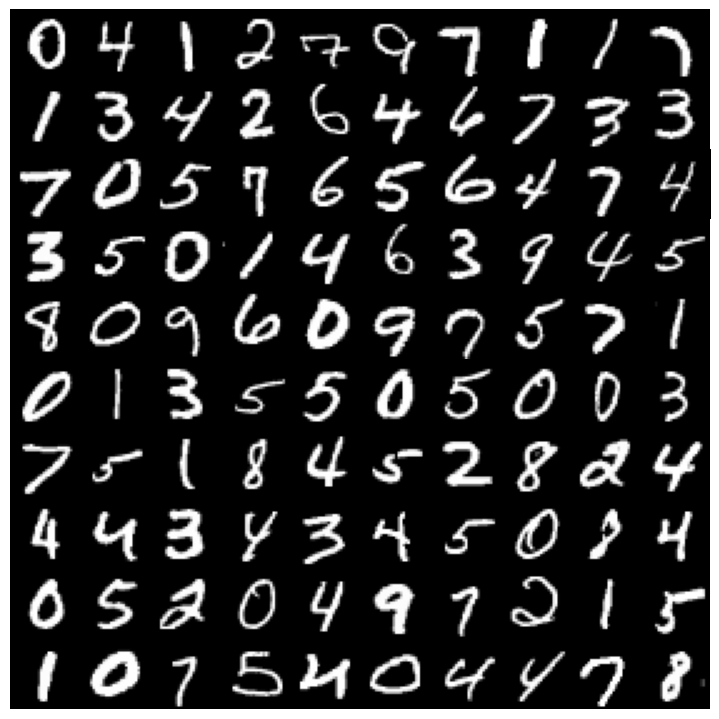

In [ ]:
#| code-fold: true
#| fig-alt: grid of digit images
#| fig-cap: Some instances from the MNIST hand-written digit dataset

def plot_digits(X, n_rows, n_cols):
    X = X.reshape(-1, 28, 28)
    n_images = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(0.7*n_cols, 0.7*n_rows))

    # Flatten axs to iterate easily
    axs = axs.flatten()

    for i in range(n_images):
        axs[i].imshow(X[i], cmap="gray")
        axs[i].axis("off")  # turn off axes completely

    # Remove all spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    # return fig, axs

plot_digits(X, 10, 10); # post image



## Logistic Regression with scikit-learn

We'll start with the traditional logistic regression model implementation from scikit-learn.

In [ ]:
# Classical Logistic Regression

clf = LogisticRegression(penalty=None, solver="sag", tol=0.1) 
clf.fit(X_train, y_train)
print(f"Test Accuracy: {100 * clf.score(X_test, y_test):.2f}%")


Test Accuracy: 89.39%


Now to visualize what this model is doing, let's have a look at its coefficients.

In [95]:
clf.coef_.shape

(10, 784)

Recall the coefficients $W$ are in a $K \times D$ array, so each of the $K$ rows contains the $D$ coefficients for the corresponding  class.
Let's reshape each of the rows into a 28 by 28 image and plot them.

In [96]:
#| code-fold: true
def plot_class_weights(weights: np.ndarray, title: str = "Classification Weights"):
    num_classes = weights.shape[0]
    n_rows, n_cols = 2, (num_classes + 1) // 2

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    scale = np.abs(weights).max()

    # Set up shared color scale
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=-scale, vmax=scale)

    axs = axs.flatten()
    for i in range(num_classes):
        ax = axs[i]
        im = ax.imshow(
            weights[i].reshape(28, 28),
            interpolation="nearest",
            cmap=cmap,
            norm=norm
        )
        ax.set_xticks(())
        ax.set_yticks(())
        # ax.set_xlabel(f"Class {i}")
        ax.set_xlabel(f"Class {i}", labelpad=5)
        ax.xaxis.set_label_position('top')

    for j in range(num_classes, len(axs)):
        axs[j].axis('off')

    # Add colorbar BELOW the entire figure
    cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.03])  # [left, bottom, width, height]
    fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal"
    ).set_label("value")

    fig.suptitle(title)
    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make space for suptitle
    plt.show()


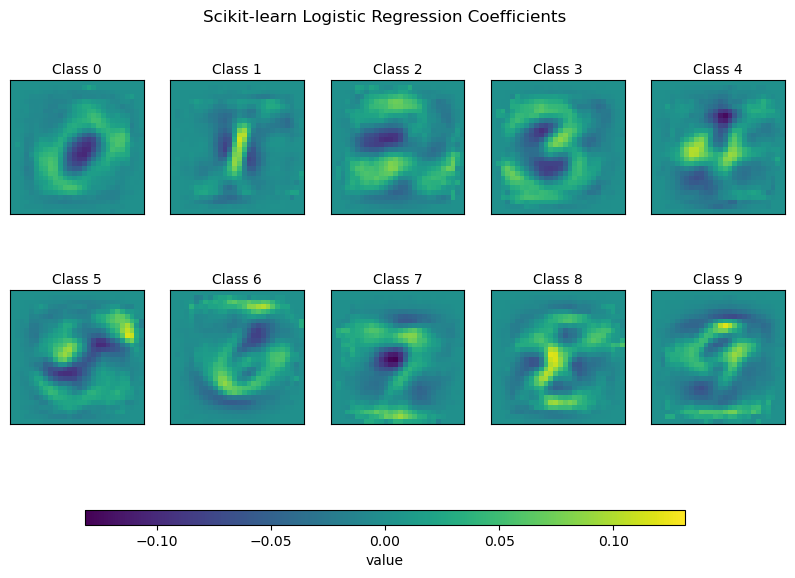

In [ ]:
#| fig-alt: Traditional logistic regression coefficients for each class 
#| fig-cap: Traditional logistic regression coefficients for each class 
plot_class_weights(clf.coef_, title="Scikit-learn Logistic Regression Coefficients")

Intuitively, for a given digit, we'd expect the coefficients to be positive on pixels where the digit is typically located, and we'd expect the coefficients to be zero or perhaps even negative on pixels where other digits tend to be located. 
We can see that's more or less what this model is doing.

## Logistic Regression in PyTorch

I recommend checking out the PyTorch [Basic Tutorial](https://docs.pytorch.org/tutorials/beginner/basics/intro.html) to get started with the library's API.
Our basic flow for creating PyTorch models will look like

1. Create `Dataset` and `DataLoader` objects. 
1. Build the model.
1. Train the model.


### Create PyTorch `Dataset` and `DataLoader` Objects

In [98]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.int64), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(np.int64), dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Build the Model

In [128]:
# Logistic Regression Model
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        self.activation = nn.LogSoftmax(dim=1) # returns log probabilities

    def forward(self, x):
        z = self.linear(x)
        p = self.activation(z)
        return p

model = LogReg()

### Train the Model

In [129]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.1

# Loss
criterion = nn.NLLLoss() # expects log probabilities

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.view(-1, 28*28)  # Flatten
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}")

Epoch [1/5], Training Loss: 0.4151
Epoch [2/5], Training Loss: 0.1858
Epoch [3/5], Training Loss: 0.1102
Epoch [4/5], Training Loss: 0.5600
Epoch [5/5], Training Loss: 0.4414


### Evaluate the Model

In [130]:
# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 90.71%


### PyTorch Model Weights

Let's take a look at the weights.

In [131]:
weights = model.linear.weight.detach().numpy()
weights.shape

(10, 784)

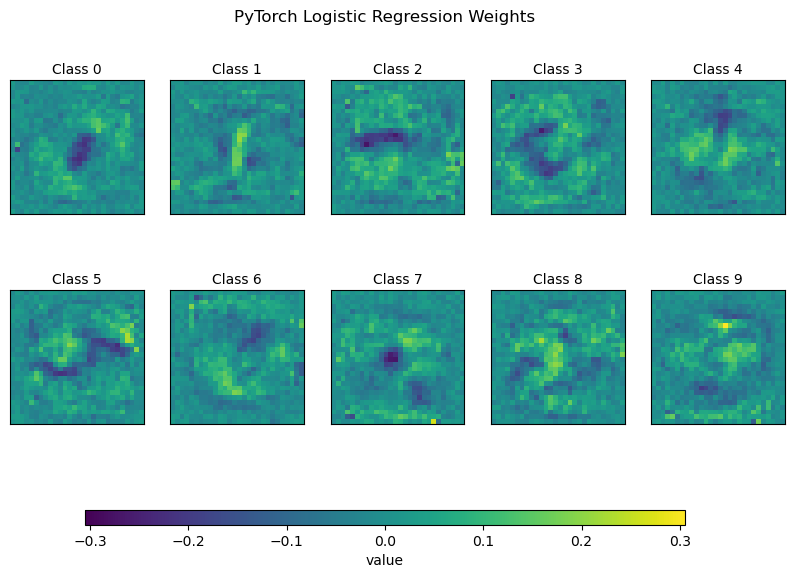

In [132]:
#| fig-alt: PyTorch logistic regression coefficients for each class 
#| fig-cap: PyTorch logistic regression coefficients for each class 
plot_class_weights(weights, title="PyTorch Logistic Regression Weights")


Nice! We can see that the weights from the neural network are qualitatively similar to the coefficients from the logistic regression model.
Interestingly, the neural network weight patterns look a bit more noisy than the classical logistic regression coefficients, and yet, the models are performing similarly on the test data (89-90%).
Likely there are a lot of logistic regression parameter solutions that yield similar performance, and these two models  have found slightly different solutions in parameter space.

## Multilayer Perceptron in PyTorch

Well, logistic regression is great and all, but of course, the reason for messing around with PyTorch is so that we can start building more interesting neural network  architectures.
The next obvious step is to build out a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP).
The MLP is a network with 

* An input layer
* One or more hidden layers comprised of a linear transformation passed to a non-linear activation function
* An output layer, e.g. returning class probabilities

When we add "hidden" layers between the input and output layers, the network earns the modifier "deep", meaning that MLP's are deep networks.
We'll build a model with two hidden layers that uses [rectified linear unit activation functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLU).
The ReLU just replaces negative inputs with zero and passes positive inputs through unchanged—a very simple form of non-linearity.

In [153]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),   # Input layer
            nn.ReLU(),
            nn.Linear(256, 128),   # Hidden layer
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)       # output layer - log probabilities
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP()

In [154]:
# Hyperparameters
num_epochs = 20
learning_rate = 0.001

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
criterion = nn.NLLLoss() # expects log probability

# Training loop
mlp.train()
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.view(-1, 28*28)  # Flatten
        outputs = mlp(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}")

Epoch [1/20], Training Loss: 0.4061
Epoch [2/20], Training Loss: 0.0821
Epoch [3/20], Training Loss: 0.0214
Epoch [4/20], Training Loss: 0.0585
Epoch [5/20], Training Loss: 0.0027
Epoch [6/20], Training Loss: 0.0086
Epoch [7/20], Training Loss: 0.0005
Epoch [8/20], Training Loss: 0.0018
Epoch [9/20], Training Loss: 0.0016
Epoch [10/20], Training Loss: 0.0809
Epoch [11/20], Training Loss: 0.0024
Epoch [12/20], Training Loss: 0.0000
Epoch [13/20], Training Loss: 0.0002
Epoch [14/20], Training Loss: 0.0001
Epoch [15/20], Training Loss: 0.0001
Epoch [16/20], Training Loss: 0.0004
Epoch [17/20], Training Loss: 0.0015
Epoch [18/20], Training Loss: 0.0011
Epoch [19/20], Training Loss: 0.0004
Epoch [20/20], Training Loss: 0.0000


In [155]:
# Evaluate model
mlp.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = mlp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 95.83%


## Wrapping Up

Nice! In this post we've bridged the gap between classic ML and deep learning by showing that logistic regression is a special case of a neural network, building a logistic regression model in PyTorch, and then adding hidden layers to that model to obtain a multilayer perceptron.